In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from data_process.shadow_render import render_shadow
import matplotlib.pyplot as plt

import torch
from ssn import ssn_dataset
from torchvision import transforms, utils
import numpy as np
from utils.net_utils import show_batch, show_light_batch
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook
from PIL import Image
from skimage.transform import resize

Device:  cpu
dict_keys(['epoch', 'best_loss', 'model_state_dict', 'optimizer_state_dict', 'hist_train_loss', 'hist_valid_loss', 'params'])
29.03427721576238
norm: batch_norm bilinear: True activation: relu prelu: False ibl: 24 weight decay: 4e-05 scale_ibl: True small ds: True


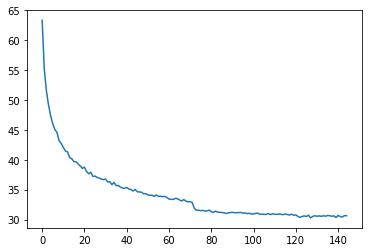

In [6]:
import os

device = torch.device("cpu")
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
# model = Relight_SSN(1,1)
weight_file = os.path.join('weights', '24_ibl_scale_18-April-11-09-PM.pt')
checkpoint = torch.load(weight_file, map_location=device)    
# model.to(device)
# model.load_state_dict(checkpoint['model_state_dict'])

print(checkpoint.keys())
print(checkpoint['best_loss'])
print(checkpoint['params'])


hist_loss = checkpoint['hist_train_loss']

plt.figure()
plt.plot(hist_loss)

In [ ]:
from valid_relight_ssn import predict, compute_ibl

In [ ]:
import matplotlib.pyplot as plt
def show_np(img, title='', cmap=None):
    plt.figure(figsize=(15,10))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.show()
    

In [ ]:
from ssn.ssn_dataset import Mask_Transform, ToTensor, IBL_Transform

def show_np(img, cmap='gray', title=''):
    h,w,c = img.shape
    
    plt.figure(figsize=(15,10))
    plt.title(title)
    if c == 1:
        plt.imshow(np.squeeze(img), cmap=cmap, interpolation='bilinear')
    else:
        plt.imshow(np.squeeze(img),  interpolation='bilinear')
    plt.show()
    
def to_one_batch(img_tensor):
    c,h,w = img_tensor.size()
    return img_tensor.view(1,c,h,w)

def to_numpy(one_batch):
    return one_batch[0].detach().cpu().numpy().transpose((1,2,0))

def png_to_3channel(img):
    """ mask image from 4 channel png to 3 channel"""
    h,w,c = img.shape
    if c != 4:
        print("image is not 4 channel")
        return img
    
    out_img, alpha = img[:,:,0:3]/255.0, img[:,:,3]/255.0
    out_img[:,:,0] = out_img[:,:,0] * alpha
    out_img[:,:,1] = out_img[:,:,1] * alpha
    out_img[:,:,2] = out_img[:,:,2] * alpha
    out_img = out_img * 255.9
    out_img = out_img.astype(np.uint8)
    return out_img

def padding_image(img, padding_size_w, padding_size_h):
    """ padding an image with a padding size """
    padding_size_w = int(padding_size_w)
    padding_size_h = int(padding_size_h)
    
    if padding_size_w == 0 and padding_size_h == 0:
        return img
    
    h, w = img.shape[:2]
    if len(img.shape) == 2:
        c = 1
    else:
        c = img.shape[-1]
    
    img = img.reshape((h,w,c))
    out_img = np.zeros((h + 2 * padding_size_h, w + 2 * padding_size_w, c),dtype=np.float64)
    out_img[padding_size_h:padding_size_h + h, padding_size_w:padding_size_w + w, 0:c] = img[:,:,0:c]
    return out_img

def crop_bb(img_mask):
    img_mask = img_mask[:,:,0] + img_mask[:,:,1] + img_mask[:,:,2]
    i, j = np.where(img_mask != 0)
    
    min_i, min_j = np.min(i), np.min(j)
    max_i, max_j = np.max(i), np.max(j)
    
    return min_i, min_j, max_i, max_j

def real_to_mask(img, mask_size=30):
    mask = img[:,:,-1]
    img = png_to_3channel(img)
    
    # crop the bb
    min_i, min_j, max_i, max_j = crop_bb(img)
    img = img[min_i:max_i, min_j:max_j, :]
    mask = mask[min_i:max_i, min_j:max_j]
    
    resize_w, resize_h = mask_size, int(mask_size * (max_i-min_i)/(max_j-min_j))
    img = resize(img, (resize_h, resize_w))
    img = padding_image(np.array(img), (256 - resize_w)//2, (256 - resize_h)//2)
    img = resize(img, (256, 256))
    
    mask = resize(mask, (resize_h, resize_w))
    mask = padding_image(mask, (256 - resize_w)//2, (256 - resize_h)//2)
    mask = resize(mask, (256, 256))
    
    thresh_hold = 0.3
    mask[np.where(mask < thresh_hold)] = 0.0
    mask[np.where(mask >= thresh_hold)] = 1.0
    
    mask = np.squeeze((mask * 255.9).astype(np.uint8))
    mask = np.array([mask,] * 3).transpose((1,2,0))
    
    return img, mask

def merge_result(mask, img, shadow):
    h,w,c = shadow.shape
    if c==1:
        merged = np.zeros((h,w,3), dtype=shadow.dtype)
        merged[:,:,0], merged[:,:,1], merged[:,:,2] = shadow[:,:,0],shadow[:,:,0],shadow[:,:,0]
    else:
        merged = np.copy(shadow)
    
    merged[np.where(mask!=0)] = img[np.where(mask!=0)]
    return merged

def synthetic_to_mask(img):
    img = img[:,:,0:3]
    img = resize(img, (256,256))

    h,w,c = img.shape
    mask = np.zeros((h,w,3), dtype=np.uint8)
    mask[np.where(img != 0)] = 255
    return img, mask

def plot_result(ibls, shadow, mask, img, title='', save_path=''):
    ibl = ibls[0]
    for i in range(1, len(ibls)):
        ibl += ibls[i]
    ibl = ibl / len(ibls)
    fliped_shadow = flip_back(ibls, shadow)
    fliped_shadow = fliped_shadow/ np.max(fliped_shadow)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(20,15)
    fig.suptitle(title)
    ax1.imshow(np.clip(np.squeeze(ibl),0.0,1.0),cmap='gray')
    ax2.imshow(np.clip(np.squeeze(shadow),0.0,1.0), cmap='plasma')
    ax3.imshow(np.clip(merge_result(mask, img, fliped_shadow),0.0,1.0))
    
    if save_path != '':
        fig.savefig(save_path)

def flip_back(ibls, shadow):
    """ ibls: list of np ibl
        shadow: np image
    """ 
    sum_scale = 0
    for ibl in ibls:
        sum_scale += np.max(ibl)
        
    return -shadow + sum_scale
        
img_trnsf = transforms.Compose([
    Mask_Transform(),
    ToTensor()
])
ibl_trnsf = transforms.Compose([
    # IBL_Transform(),
    ToTensor()
])

In [ ]:
testing_fname = '/home/ysheng/Dataset/soft_shadow/real_human_testing_set/10944340-young-man-standing.png'

testing_img = Image.open(testing_fname)
testing_img, testing_mask = real_to_mask(np.array(testing_img))

show_np(testing_img)
show_np(testing_mask)

syn_testing_fname = '/home/ysheng/Dataset/soft_shadow/train/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/imgs/0000000_mask.png'
syn_testing_img, syn_testing_mask = synthetic_to_mask(np.array(Image.open(syn_testing_fname)))
show_np(syn_testing_img)
show_np(syn_testing_mask)

In [ ]:
experiment_path = 'results/exps'
os.makedirs(experiment_path, exist_ok=True)

## Multiple IBL

In [ ]:
experiment_folder = os.path.join(experiment_path,'even_multiple_ibl')
os.makedirs(experiment_folder, exist_ok=True)

def multiple_ibl_experiment(testing_mask, testing_img, prefix, exp_path):
    ibl_row_begin, ibl_row_end = 165, 190
    ibl_col = 512

    max_ibl = 12
    num_random_ibl_list = range(1, max_ibl)
    for i in tqdm(num_random_ibl_list):    
    #     random_rows = np.random.randint(ibl_row_begin, ibl_row_end, size=i)
    #     random_cols = np.random.randint(0, 512, size=i)
        step_size = (512-10) // i
        random_cols = range(10, 512, step_size)
        random_rows = [ibl_row_begin] * i

        test_ibl = compute_ibl(random_cols[0], random_rows[0])
        
        ibl_np_list = [test_ibl]
        for j in range(1, i):
            test_ibl += compute_ibl(random_cols[j], random_rows[j])
            ibl_np_list.append(test_ibl)
            
        h,w = test_ibl.shape
        test_ibl = np.reshape(test_ibl, (h,w,1))

        predicted_img = predict(testing_mask, test_ibl)/i
        title = '{} ibl'.format(i)

        save_path = os.path.join(experiment_folder, prefix + '_' + title + '.pdf')
        plot_result(ibl_np_list, predicted_img, testing_mask, 1.0 - testing_mask, title, save_path)
        
        
# multiple_ibl_experiment(testing_mask, testing_img, 'real_human', experiment_folder)
multiple_ibl_experiment(syn_testing_mask, syn_testing_img, 'real_human', experiment_folder)

## Bigger Gaussion

In [ ]:
import random
experiment_folder = os.path.join(experiment_path,'bigger_radius')
os.makedirs(experiment_folder, exist_ok=True)

step_size = (256 // 16)//2 
max_size = 3

random.seed(19920208)

def compute_ori_ibl(i,j,w=512, h=256):
    ibl = np.zeros((h,w,1))
    ibl[j,i] = 1.0
    return ibl

begin_i, begin_j = 256, 160
for i in tqdm(range(max_size)):   
    ibl_ori = compute_ori_ibl(begin_i, begin_j)
    
    test_ibl = compute_ibl(begin_i, begin_j)
    ibls = [test_ibl]
    for x in range(i+1):
        for y in range(i+1):
            if x == 0 and y == 0:
                continue
            
            new_ibl = compute_ibl(begin_i + x * step_size, begin_j + y * step_size)
            ibls.append(new_ibl)
            test_ibl += new_ibl
            ibl_ori += compute_ori_ibl(begin_i + x * step_size, begin_j + y * step_size)
            
    h,w = test_ibl.shape
    test_ibl = np.reshape(test_ibl, (h,w,1))
    
    predicted_img = predict(testing_mask, test_ibl)/((i+1)* (i+1))
    # clipping 
    np.clip(predicted_img, 0.0, 1.0, out=predicted_img)
    
    title = 'square size {}'.format(i + 1)
    print(np.min(predicted_img), np.max(predicted_img))
    
    save_path = os.path.join(experiment_folder, title + '.pdf')
    plot_result(ibls, predicted_img, testing_mask, testing_img, title, save_path)
    show_np(ibl_ori)

## Real human 

In [ ]:
experiment_folder = os.path.join(experiment_path, 'real_human')
os.makedirs(experiment_folder, exist_ok=True)

from utils.utils_file import get_all_files
from PIL import Image, ImageDraw


real_human_img_path = get_all_files('real_human')
print('human imgs: {}'.format(len(real_human_img_path)))

testing_ibl = compute_ibl(512//4, 160).reshape((16,32,1))
for f in tqdm(real_human_img_path):
    cur_human_img = Image.open(os.path.join('real_human', f))
    cur_testing_img, cur_testing_mask = real_to_mask(np.array(cur_human_img))
    
    predicted_img = predict(cur_testing_mask, testing_ibl)
    title = '{}'.format(os.path.splitext(os.path.basename(f))[0])
    save_path = os.path.join(experiment_folder, title + '.pdf')
    plot_result([testing_ibl], predicted_img, cur_testing_mask, cur_testing_img, title, save_path)

## Scale IBL

In [ ]:
experiment_folder = os.path.join(experiment_path, 'scale ibl')
os.makedirs(experiment_folder, exist_ok=True)

syn_testing_fname = '/home/ysheng/Dataset/soft_shadow/train/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/imgs/0000000_mask.png'
syn_testing_img, syn_testing_mask = synthetic_to_mask(np.array(Image.open(syn_testing_fname)))
ibl_scale_num = 10
for i in tqdm(range(ibl_scale_num)):
    ibl_intensity = 1/(ibl_scale_num-1) * i
    testing_ibl = compute_ibl(512//4, 160).reshape((16,32,1))
    testing_ibl = testing_ibl * ibl_intensity
    
    predicted_img = predict(syn_testing_mask, testing_ibl)
    title = 'scale {}, shadow range: {},{}'.format(ibl_intensity, np.min(predicted_img), np.max(predicted_img))
    save_path = os.path.join(experiment_folder, title + '.pdf')
    plot_result([testing_ibl], predicted_img, syn_testing_mask, 1.0 - syn_testing_mask, title, save_path)